In [22]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import albumentations as A
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader, Dataset

In [23]:
train_img_path = 'dataset/archive/Kvasir-SEG/Kvasir-SEG/images'
train_mask_path = 'dataset/archive/Kvasir-SEG/Kvasir-SEG/masks'

train_img_lst = os.listdir(train_img_path)
train_mask_lst = os.listdir(train_mask_path)


In [25]:
bbox_path = 'dataset/archive/Kvasir-SEG/Kvasir-SEG/bbox'

# Check if the paths exist
if not os.path.exists(train_img_path):
    print(f"Error: The directory {train_img_path} does not exist.")
else:
    train_img_lst = os.listdir(train_img_path)
    print("Number of training images:", len(train_img_lst))
    print("First few training images:", train_img_lst[:5])

if not os.path.exists(bbox_path):
    print(f"Error: The directory {bbox_path} does not exist.")
else:
    bbox_lst = os.listdir(bbox_path)
    print("Number of bounding box files:", len(bbox_lst))
    print("First few bounding box files:", bbox_lst[:5])

Number of training images: 1000
First few training images: ['cju0qkwl35piu0993l0dewei2.jpg', 'cju0qoxqj9q6s0835b43399p4.jpg', 'cju0qx73cjw570799j4n5cjze.jpg', 'cju0roawvklrq0799vmjorwfv.jpg', 'cju0rx1idathl0835detmsp84.jpg']
Number of bounding box files: 1000
First few bounding box files: ['cju0qkwl35piu0993l0dewei2.csv', 'cju0qoxqj9q6s0835b43399p4.csv', 'cju0qx73cjw570799j4n5cjze.csv', 'cju0roawvklrq0799vmjorwfv.csv', 'cju0rx1idathl0835detmsp84.csv']


In [26]:
sorted_train_mask_lst = sorted(train_mask_lst)
sorted_train_img_lst = sorted(train_img_lst)

print(sorted_train_mask_lst[:5])
print(sorted_train_img_lst[:5])

['cju0qkwl35piu0993l0dewei2.jpg', 'cju0qoxqj9q6s0835b43399p4.jpg', 'cju0qx73cjw570799j4n5cjze.jpg', 'cju0roawvklrq0799vmjorwfv.jpg', 'cju0rx1idathl0835detmsp84.jpg']
['cju0qkwl35piu0993l0dewei2.jpg', 'cju0qoxqj9q6s0835b43399p4.jpg', 'cju0qx73cjw570799j4n5cjze.jpg', 'cju0roawvklrq0799vmjorwfv.jpg', 'cju0rx1idathl0835detmsp84.jpg']


dataset/archive/Kvasir-SEG/Kvasir-SEG/images\cju0qkwl35piu0993l0dewei2.jpg
(622, 529)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


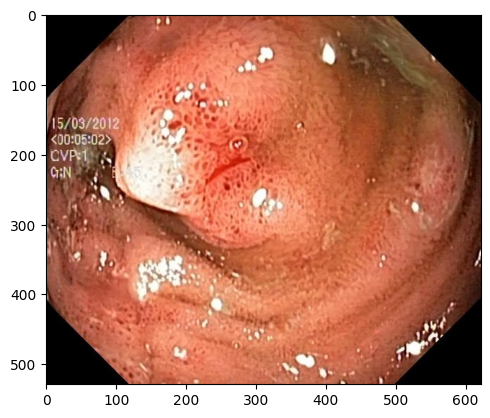

dataset/archive/Kvasir-SEG/Kvasir-SEG/masks\cju0qkwl35piu0993l0dewei2.jpg
(622, 529)


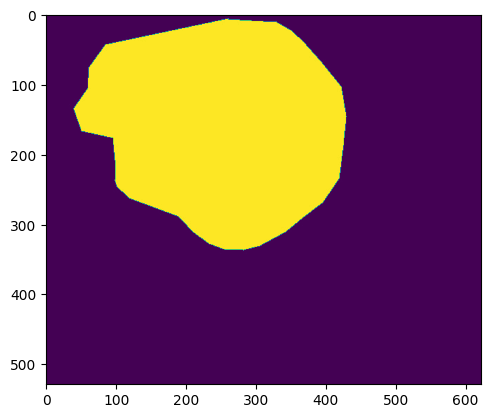

----------------------------------------------------
dataset/archive/Kvasir-SEG/Kvasir-SEG/images\cju0qoxqj9q6s0835b43399p4.jpg
(1348, 1070)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


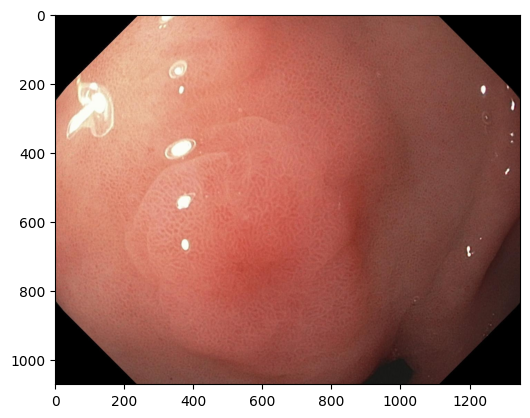

dataset/archive/Kvasir-SEG/Kvasir-SEG/masks\cju0qoxqj9q6s0835b43399p4.jpg
(1348, 1070)


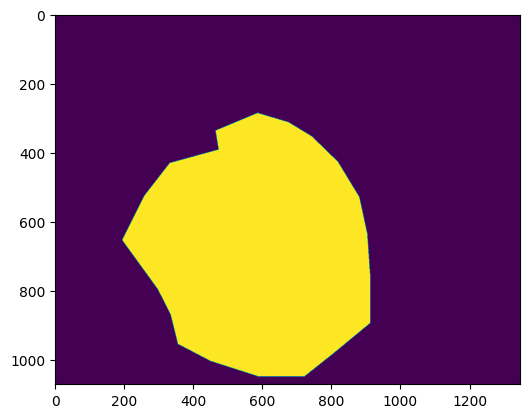

----------------------------------------------------


In [27]:
def show_images(imgs_lst,masks_lst,loops=2):
    for i in range(loops):
        img_path = os.path.join(train_img_path,imgs_lst[i])
        mask_path = os.path.join(train_mask_path,masks_lst[i])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        print(img_path)
        print(img.size)
        print(type(img))
        plt.imshow(img)
        plt.show()
        print(mask_path)
        print(mask.size)
        plt.imshow(mask)
        plt.show()
        print("----------------------------------------------------")

show_images(sorted_train_img_lst, sorted_train_mask_lst)

In [28]:
class CFG:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    split_pct = 0.2
    learning_rate = 3e-4
    batch_size = 4
    epochs = 3


In [29]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

In [30]:
CFG.device

device(type='cpu')

In [31]:
permuted_train_img_lst = np.random.permutation(np.array(sorted_train_img_lst))
permuted_train_mask_lst = [x.replace(".jpg", ".jpg") for x in permuted_train_img_lst]
print(permuted_train_img_lst[:5])
print(permuted_train_mask_lst[:5])

['cju2hjrqcvi2j0801bx1i6gxg.jpg' 'cju2rlqdnoz9k0993cpjae3x0.jpg'
 'cju18kevfrojc0835bn90f1in.jpg' 'cju5vzjoslpj708186z2fusmz.jpg'
 'cju2hx006vidl0799igm81vmh.jpg']
['cju2hjrqcvi2j0801bx1i6gxg.jpg', 'cju2rlqdnoz9k0993cpjae3x0.jpg', 'cju18kevfrojc0835bn90f1in.jpg', 'cju5vzjoslpj708186z2fusmz.jpg', 'cju2hx006vidl0799igm81vmh.jpg']


dataset/archive/Kvasir-SEG/Kvasir-SEG/images\cju2hjrqcvi2j0801bx1i6gxg.jpg
(599, 531)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


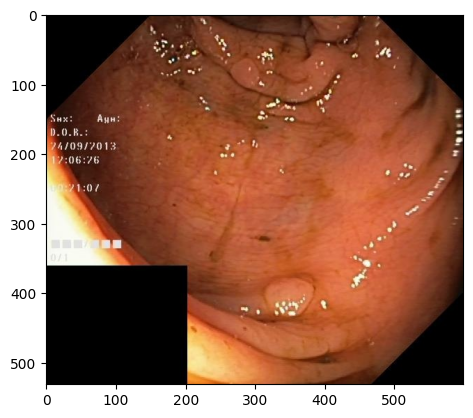

dataset/archive/Kvasir-SEG/Kvasir-SEG/masks\cju2hjrqcvi2j0801bx1i6gxg.jpg
(599, 531)


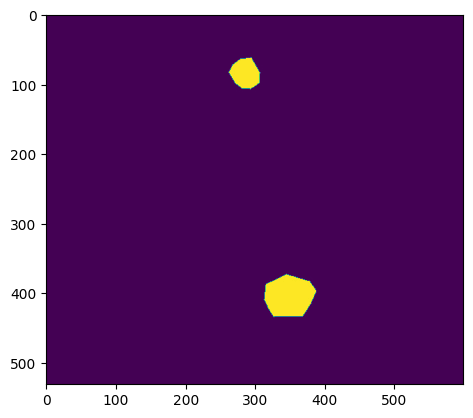

----------------------------------------------------
dataset/archive/Kvasir-SEG/Kvasir-SEG/images\cju2rlqdnoz9k0993cpjae3x0.jpg
(592, 531)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


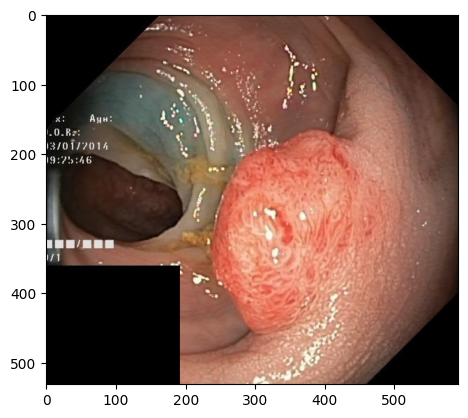

dataset/archive/Kvasir-SEG/Kvasir-SEG/masks\cju2rlqdnoz9k0993cpjae3x0.jpg
(592, 531)


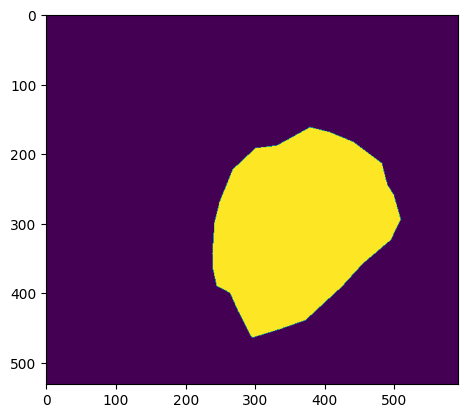

----------------------------------------------------


In [32]:
show_images(permuted_train_img_lst,permuted_train_mask_lst)

In [33]:
length = len(permuted_train_img_lst)
print(length*0.2) # convert this to int

200.0


In [34]:
train_images_list = permuted_train_img_lst[int(CFG.split_pct*len(permuted_train_img_lst)) :]
train_masks_list = permuted_train_mask_lst[int(CFG.split_pct*len(permuted_train_mask_lst)) :]
print(len(train_masks_list))

val_images_list = permuted_train_img_lst[: int(CFG.split_pct*len(permuted_train_img_lst))]
val_masks_list = permuted_train_mask_lst[: int(CFG.split_pct*len(permuted_train_mask_lst))]
print(len(val_masks_list))

800
200


In [35]:
class kvasirsegDataset(Dataset):
    def __init__(self,img_list,mask_list,transform=None):
        self.img_list = img_list
        self.mask_list = mask_list
        self.transform = transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,index):
        img_path = os.path.join(train_img_path,self.img_list[index])
        mask_path = os.path.join(train_mask_path,self.mask_list[index])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        img = np.array(img)
        mask = np.array(mask)
        mask[mask==255.0] = 1.0
        #img_mask_dict = {"image": img, "mask": mask}
        
        if self.transform:
            augmentation = self.transform(image=img, mask=mask)
            img = augmentation["image"]
            mask = augmentation["mask"]
            mask = torch.unsqueeze(mask,0)
            #transformations = self.transform(image=img, mask=mask)
            #img = transformations["image"]
            #mask = transformations["mask"]
            
        return img,mask

In [36]:
train_transform = A.Compose([A.Resize(256,256), 
                             A.Rotate(limit=15,p=0.1),
                             A.HorizontalFlip(p=0.5),
                             A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                             ToTensorV2()])

val_transform = A.Compose([A.Resize(256,256),
                           A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                           ToTensorV2()])

In [37]:
train_dataset = kvasirsegDataset(train_images_list, train_masks_list, transform = train_transform)
val_dataset = kvasirsegDataset(val_images_list, val_masks_list, transform = train_transform)

In [38]:
idx = 200
img,mask = train_dataset[idx]

In [39]:
mask.shape

torch.Size([1, 256, 256])

In [40]:
img.max()

tensor(1.)

In [41]:
def show_single_img(img,mask,index=None,train=True):
    if index:
        if train:
            img,mask = train_dataset[index]
        else:
            img,mask = val_dataset[index]
    plt.imshow(img.permute(1,2,0),cmap="gray")  # Convert (3, 512, 512) -> (512, 512, 3)
    plt.show()
    plt.imshow(mask.permute(1,2,0), cmap="gray")  # Convert (1, 572, 572) -> (572, 572, 1)
    print(mask.shape)
    plt.show()

---------------Train---------------


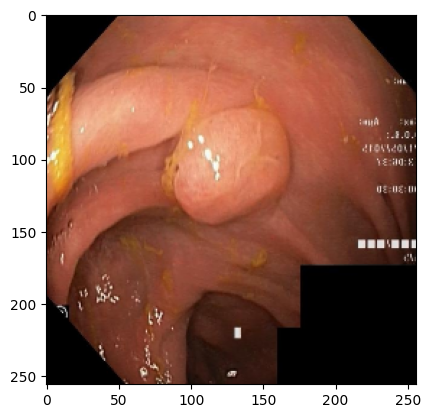

torch.Size([1, 256, 256])


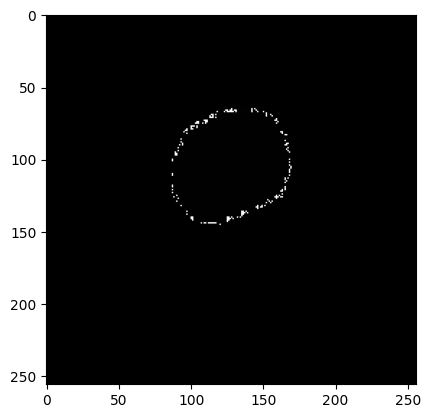

---------------Validation--------------


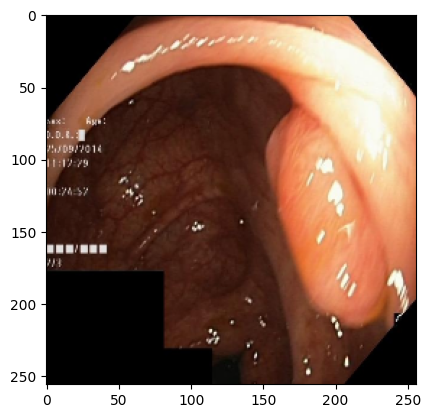

torch.Size([1, 256, 256])


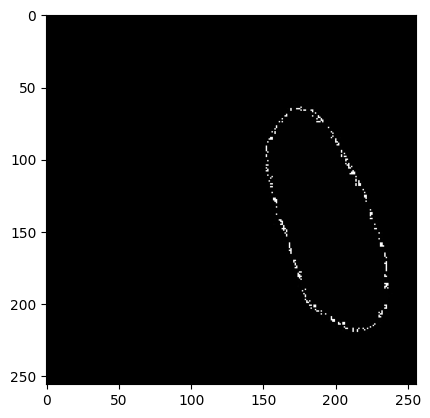

In [42]:
print("---------------Train---------------")
show_single_img(img,mask,index=15,train=False)
print("---------------Validation--------------")
show_single_img(img,mask,index=15,train=True)

In [43]:
#dataloader
train_dataloader = DataLoader(train_dataset,batch_size=CFG.batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=CFG.batch_size,shuffle=False)

In [44]:
#a = iter(train_dataloader)
img,mask = next(iter(train_dataloader))
print(img.shape,mask.shape)

torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])


In [45]:
import torch
import torch.nn as nn


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, height, width):
        super().__init__()
        self.height = height
        self.width = width
        self.pe = nn.Parameter(torch.randn(1, d_model, height, width))

    def forward(self, x):
        return x + self.pe[:, :, :x.size(2), :x.size(3)]


class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout):
        super().__init__()
        self.self_attention = nn.MultiheadAttention(d_model, nhead)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model),
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        src2 = self.self_attention(src, src, src)[0]
        src = src + self.dropout(src2)
        src = self.norm1(src)
        src2 = self.feed_forward(src)
        src = src + self.dropout(src2)
        src = self.norm2(src)
        return src


class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout):
        super().__init__()
        self.self_attention = nn.MultiheadAttention(d_model, nhead)
        self.encoder_attention = nn.MultiheadAttention(d_model, nhead)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model),
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, memory,tgt):
        tgt2 = self.self_attention(tgt, tgt, tgt)[0]
        tgt = tgt + self.dropout(tgt2)
        tgt = self.norm1(tgt)
        tgt2 = self.encoder_attention(tgt, memory, memory)[0]
        tgt = tgt + self.dropout(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.feed_forward(tgt)
        tgt = tgt + self.dropout(tgt2)
        tgt = self.norm3(tgt)
        return tgt

class TransformerSegmentationModel(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=64,
        d_model=512,
        nhead=8,
        dim_feedforward=2048,
        num_encoder_layers=6,
        num_decoder_layers=6,
        dropout=0.1,
        height=256,
        width=256,
    ):
        super().__init__()

        self.encoder = nn.ModuleList(
            [
                TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
                for _ in range(num_encoder_layers)
            ]
        )
        self.decoder = nn.ModuleList(
            [
                TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
                for _ in range(num_decoder_layers)
            ]
        )
        self.positional_encoding = PositionalEncoding(d_model, height, width)
        self.fc = nn.Conv2d(d_model, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.positional_encoding(x)
        for encoder_layer in self.encoder:
            x = encoder_layer(x)
        for decoder_layer in self.decoder:
            x = decoder_layer(x, x)
        x = self.fc(x)
        return x

In [46]:
class Mymodel(nn.Module):
    def _enc_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _dec_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
  
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )

        self.enc_conv0 = nn.Sequential(self._enc_layer(3, 64))
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(self._enc_layer(64, 128))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(self._enc_layer(128, 256))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(self._enc_layer(256, 512))
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16
        
        self.transformer = nn.Transformer()

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(self._dec_layer(512, 256))
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(self._dec_layer(256, 128))
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(self._dec_layer(128, 64))
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            self._dec_layer(64, 64),
            nn.ConvTranspose2d(64, 1, kernel_size=(3, 3), padding=(1, 1)),
            # nn.BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            # nn.ReLU(inplace=True)
       )

    '''def forward(self, x):
        # encoder
        e0, idx0 = self.pool0(self.enc_conv0(x))
        e1, idx1 = self.pool1(self.enc_conv1(e0))
        e2, idx2 = self.pool2(self.enc_conv2(e1))
        e3, idx3 = self.pool3(self.enc_conv3(e2))

        t1 = self.transformer(e3,e3)
        
        # decoder
        d0 = self.dec_conv0(self.upsample0(e3, idx3))
        d1 = self.dec_conv1(self.upsample1(d0, idx2))
        d2 = self.dec_conv2(self.upsample2(d1, idx1))
        d3 = self.dec_conv3(self.upsample3(d2, idx0))
        d3 = F.sigmoid(d3)
        return d3'''
    def forward(self, x):
        e0, idx0 = self.pool0(self.enc_conv0(x))
        e1, idx1 = self.pool1(self.enc_conv1(e0))
        e2, idx2 = self.pool2(self.enc_conv2(e1))
        e3, idx3 = self.pool3(self.enc_conv3(e2))

    # reshape the encoder output to match the expected dimensions of the transformer
        b, c, h, w = e3.size()
        e3 = e3.view(b, c, h * w).permute(2, 0, 1)  # reshape to (h*w, b, c)

    # apply the transformer to the reshaped encoder output
        t1 = self.transformer(e3, e3)

    # reshape the transformer output back to the original shape
        t1 = t1.permute(1, 2, 0).view(b, c, h, w)

    # decoder
        d0 = self.dec_conv0(self.upsample0(t1, idx3))
        d1 = self.dec_conv1(self.upsample1(d0, idx2))
        d2 = self.dec_conv2(self.upsample2(d1, idx1))
        d3 = self.dec_conv3(self.upsample3(d2, idx0))
        d3 = torch.sigmoid(d3)
        return d3

In [47]:
#training &loading
def train_model(model,dataloader,criterion,optimizer):
    model.train()
    train_running_loss = 0.0
    for j,img_mask in enumerate(tqdm(dataloader)):
        img = img_mask[0].float().to(CFG.device)
        #print(" ----- IMAGE -----")
        #print(img)
        mask = img_mask[1].float().to(CFG.device)
        #print(" ----- MASK -----")
        #print(mask)
        
        y_pred = model(img)
        #print(" ----- Y PRED -----")
        #print(y_pred)
        #print(" ----- Y PRED SHAPE -----")#
        #print(y_pred.shape)
        optimizer.zero_grad()
        
        loss = criterion(y_pred,mask)
        
        train_running_loss += loss.item() * CFG.batch_size
        
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / (j+1)
    return train_loss

In [51]:
def val_model(model,dataloader,criterion,optimizer):
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for j,img_mask in enumerate(tqdm(dataloader)):
            img = img_mask[0].float().to(CFG.device)
            mask = img_mask[1].float().to(CFG.device)
            y_pred = model(img)
            loss = criterion(y_pred,mask)
            
            val_running_loss += loss.item() * CFG.batch_size
            
        val_loss = val_running_loss / (j+1)
    return val_loss

In [52]:
model = Mymodel().to(CFG.device)
optimizer = optim.Adam(model.parameters(), lr = CFG.learning_rate)
criterion = nn.BCEWithLogitsLoss()
train_loss_lst = []
val_loss_lst = []

In [53]:
for i in tqdm(range(CFG.epochs)):
    train_loss = train_model(model=model,dataloader=train_dataloader,criterion=criterion,optimizer=optimizer)
    val_loss = val_model(model=model,dataloader=val_dataloader,criterion=criterion,optimizer=optimizer)
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)
    print(f" Train Loss : {train_loss:.4f}")
    print(f" Validation Loss : {val_loss:.4f}")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 Train Loss : 0.3154
 Validation Loss : 0.3207


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 Train Loss : -0.0030
 Validation Loss : 0.1352


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 Train Loss : -0.0997
 Validation Loss : 0.1210
